## Notebook to help to work with Hyper images in mask2former

In [1]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np

import os, cv2, random

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

El error de arriba era el problema esperado al tratar de cargar imágenes hyperespectrales.

El error lo causa PIL porque no se espera una imagen RGB y recibe una (B, G, R, Nir.) entonces el método de lectura lanza un PIL.UnidentifiedImageError – If the image cannot be opened and identified.

https://github.com/python-pillow/Pillow/issues/1888 Esto lleva abierto desde el 2016, es una solicitud para que Pillow añada soporte a imágenes de 16 bits, ahora mismo solo soporta imágenes de 16 bits si tiene 1 solo canal.

La única solucion que vi en un principio es hacer uso de la librería tifffile.


In [3]:
from PIL import Image
import numpy as np

# Open the TIFF file
tiff_image = Image.open("/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000564539-MSS1.tiff")

# Ensure the image is in RGBA mode or convert it to RGBA
if tiff_image.mode != 'RGBA':
    tiff_image = tiff_image.convert('RGBA')

# Convert the image to a NumPy array
tiff_array = np.array(tiff_image)

# Extract individual channels (assuming B, G, R, Nir order)
blue_channel = tiff_array[:, :, 0]
green_channel = tiff_array[:, :, 1]
red_channel = tiff_array[:, :, 2]
nir_channel = tiff_array[:, :, 3]

# For demonstration, print the shape of each channel
print("Blue channel shape:", blue_channel.shape)
print("Green channel shape:", green_channel.shape)
print("Red channel shape:", red_channel.shape)
print("NIR channel shape:", nir_channel.shape)

# Now you can work with individual channels as needed


UnidentifiedImageError: cannot identify image file '/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000564539-MSS1.tiff'

In [4]:
import tifffile as tiff
import numpy as np

# Read the TIFF file
tiff_image = tiff.imread("/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000564539-MSS1.tiff")

# Check the shape of the image to understand the channel order and dimensions
print("TIFF image shape:", tiff_image.shape)

# Assuming the image has shape (height, width, channels)
# and the channels are ordered as B, G, R, Nir
if tiff_image.shape[2] == 4:
    blue_channel = tiff_image[:, :, 0]
    green_channel = tiff_image[:, :, 1]
    red_channel = tiff_image[:, :, 2]
    nir_channel = tiff_image[:, :, 3]

    # For demonstration, print the shape of each channel
    print("Blue channel shape:", blue_channel.shape)
    print("Green channel shape:", green_channel.shape)
    print("Red channel shape:", red_channel.shape)
    print("NIR channel shape:", nir_channel.shape)
else:
    print("Unexpected number of channels:", tiff_image.shape[2])


TIFF image shape: (6908, 7300, 4)
Blue channel shape: (6908, 7300)
Green channel shape: (6908, 7300)
Red channel shape: (6908, 7300)
NIR channel shape: (6908, 7300)


Para arreglar esto tendría que modificar el código de DETECTRON:

detectron2/detectron2/data/detection_utils.py

y añadir un método nuevo que trabaje con TIFFILE para poder cargar las imágenes.

Lo que hice fue añadir una comprobacion al semantic mapper para ver si la extension de la imagen es TIFF, si es así se lee la imagen haciendo uso de tiffile y despues se convierte de 16 bits a 8 bits. Entiendo que está bien porque ahora el error sucede cuando trata de poner a entrenar la red:

File "/home/pablo.canosa/wip/Mask2Former/mask2former/maskformer_model.py", line 194, in <listcomp>
images = [(x - self.pixel_mean) / self.pixel_std for x in images]
RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

https://github.com/facebookresearch/Mask2Former/blob/main/ADVANCED_USAGE.md

Entiendo que tengo que cambiar los siferentes componentes para que trabajen con imagenes hyperespectrales

In [30]:
path = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"
image_shapes=[]
for image in os.listdir(path):
    img = cv2.imread(path + image)
    if img.shape not in image_shapes:
        image_shapes.append(img.shape)

print(image_shapes)
#Ahora ya deberían estar arreglados los tamaños de las imágenes


[(6908, 7300, 3)]


In [31]:
path = "/home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/"
image_shapes=[]
for image in os.listdir(path):
    img = cv2.imread(path + image)
    if img.shape not in image_shapes:
        image_shapes.append(img.shape)

print(image_shapes)
#Ahora ya deberían estar arreglados los tamaños de las imágenes

[(6908, 7300, 3)]


In [14]:
path = "/home/pablo.canosa/old_tfm_data/gaofen/Image__8bit_NirRGB/"
image_shapes=[]
for image in os.listdir(path):
    img = cv2.imread(path + image)
    if img.shape not in image_shapes:
        image_shapes.append(img.shape)

print(image_shapes)

[(6908, 7300, 3)]


In [11]:
image = tiff.imread("/home/pablo.canosa/old_tfm_data/gaofen/Image_16bit_BGRNir/GF2_PMS2__L1A0001723989-MSS2.tiff")

print(image.shape)
zeros_array = np.zeros((1, 7300, 4))

# Stack the original array and the zeros array vertically
new_array = np.vstack((image, zeros_array))
print(new_array.shape)

(6907, 7300, 4)
(6908, 7300, 4)


Mask2Former/mask2former/modeling/pixel_decoder/ops/functions/ms_deform_attn_func.py


this file forward method returns a shape with a shape [1,14175,256]

In [3]:
#Fix the images
from osgeo import gdal

# Path to the TIFF file
tiff_file_path = '/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000564539-MSS1.tiff'

# Open the TIFF file
dataset = gdal.Open(tiff_file_path, gdal.GA_ReadOnly)

# Check if the file was successfully opened
if not dataset:
    print("Failed to open the file.")
else:
    print("File opened successfully.")

    # Get basic information about the file
    print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                                 dataset.GetDriver().LongName))
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                        dataset.RasterYSize,
                                        dataset.RasterCount))
    print("Projection is {}".format(dataset.GetProjection()))

    # Get geotransform
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Accessing the first band
    band = dataset.GetRasterBand(1)
    if band:
        # Get statistics
        stats = band.GetStatistics(True, True)
        if stats:
            print("Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % (
                stats[0], stats[1], stats[2], stats[3]))

        # Read as array
        data = band.ReadAsArray()
        print("Data type: ", data.dtype)
        print("Array shape: ", data.shape)

    # Close the dataset
    dataset = None


File opened successfully.
Driver: GTiff/GeoTIFF
Size is 7300 x 6908 x 4
Projection is 
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
Minimum=0.000, Maximum=929.000, Mean=405.115, StdDev=32.334
Data type:  uint16
Array shape:  (6908, 7300)


In [26]:
from osgeo import gdal

# Path to the TIFF file
tiff_file_path = '/home/pablo.canosa/wip/datasets/pruebas_gdal/GF2_PMS1__L1A0001217916-MSS1.tiff'

# Open the TIFF file in read-only mode
dataset = gdal.Open(tiff_file_path, gdal.GA_ReadOnly)

# Check if the file was successfully opened
if not dataset:
    print("Failed to open the file.")
else:
    print("File opened successfully.")

    # Get basic information about the file
    print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                                 dataset.GetDriver().LongName))
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                        dataset.RasterYSize,
                                        dataset.RasterCount))
    print("Projection is {}".format(dataset.GetProjection()))

    # Get geotransform
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Accessing the first band
    band = dataset.GetRasterBand(1)
    if band:
        # Read the data as array
        data = band.ReadAsArray()
        print("Data type: ", data.dtype)
        print("Array shape: ", data.shape)

        # Manually compute statistics to avoid creating .aux.xml file
        minimum = data.min()
        maximum = data.max()
        mean = data.mean()
        stddev = data.std()

        print("Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % (
            minimum, maximum, mean, stddev))

    # Close the dataset
    dataset = None


File opened successfully.
Driver: GTiff/GeoTIFF
Size is 7300 x 6908 x 4
Projection is 
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
Data type:  uint16
Array shape:  (6908, 7300)
Minimum=0.000, Maximum=1023.000, Mean=413.961, StdDev=62.747


## Code to fix the wrong images

In [24]:
import os
from osgeo import gdal
import numpy as np

def fix_multispectral_img(source_path, target_path):

    for image in os.listdir(source_path):
        tiff_file_path = os.path.join(source_path, image)
        dataset = gdal.Open(tiff_file_path, gdal.GA_ReadOnly)

        if not dataset:
            print(f"Failed to open the file {image}.")
        else:
            x_size = dataset.RasterXSize
            y_size = dataset.RasterYSize
            band_count = dataset.RasterCount
            projection = dataset.GetProjection()
            geotransform = dataset.GetGeoTransform()

            if y_size == 6907:
                print(f"x_size: {x_size}, y_size: {y_size}")
                print(f"File {image} has an incorrect number of rows.")

                # Create a new row with all values set to 1023
                new_row = np.full((1, x_size), 1023, dtype=np.uint16)

                new_data = []
                for band_index in range(1, band_count + 1):
                    band = dataset.GetRasterBand(band_index)
                    data = band.ReadAsArray().astype(np.uint16)

                    modified_data = np.vstack((data, new_row))
                    new_data.append(modified_data)

                    print(f"Modified Array shape for band {band_index}: ", modified_data.shape)

                output_tiff_file_path = os.path.join(target_path, image)

                driver = gdal.GetDriverByName('GTiff')
                output_dataset = driver.Create(output_tiff_file_path, x_size, y_size + 1, band_count, gdal.GDT_UInt16)

                output_dataset.SetProjection(projection)
                output_dataset.SetGeoTransform(geotransform)

                for band_index in range(band_count):
                    output_band = output_dataset.GetRasterBand(band_index + 1)
                    output_band.WriteArray(new_data[band_index])
                    output_band.FlushCache()

                output_dataset = None
                print(f"File {image} saved successfully.")

            dataset = None


In [28]:
train_folder_source = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"
test_folder_source = "/home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/"

fix_multispectral_img(train_folder_source, train_folder_source)
fix_multispectral_img(test_folder_source, test_folder_source)

In [ ]:
     
## CODIGO TEMPORAL PARA USAR GDAL EN EL MAPPER

        from osgeo import gdal
        if(dataset_dict["file_name"][-4:] == "tiff"):
            gdal_image = gdal.Open(dataset_dict["file_name"], gdal.GA_ReadOnly)
            print("Image shape: ", gdal_image.RasterYSize, gdal_image.RasterXSize, gdal_image.RasterCount)
            
            bands = []
            for band_index in range(1, gdal_image.RasterCount + 1):
                band = gdal_image.GetRasterBand(band_index)
                image = band.ReadAsArray()
                bands.append(image)
            image = np.stack(bands, axis=-1)
            gdal_image = None
            image = (image / 256).astype(np.uint8) # this is done to convert the image to from 16 bit to 8 bit
            image = image[:,:,:3]
            print("Image shape: ", image.shape)
            print(dataset_dict["file_name"])

In [6]:
#https://forum.image.sc/t/deep-learning-image-classifier-for-multichannel-images-what-is-the-best-approach/48676/9
from osgeo import gdal
from sklearn.decomposition import PCA
import numpy as np

tiff_file_path = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000647770-MSS1.tiff"
dataset = gdal.Open(tiff_file_path, gdal.GA_ReadOnly)

if not dataset:
    print(f"Failed to open the file {image}.")
else:
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    band_count = dataset.RasterCount
    projection = dataset.GetProjection()
    geotransform = dataset.GetGeoTransform()

bands = []
for band_index in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(band_index)
    image = band.ReadAsArray()
    bands.append(image)
image = np.stack(bands, axis=-1)
dataset = None


x, y, z = image.shape
image_2d = image.reshape(x*y, z)

pca = PCA(3)  # necesitamos quedar en 3 dimensiones
image_pca = pca.fit_transform(image_2d)

image_pca_3d = image_pca.reshape(x, y, 3)

print("Image shape: ", image_pca_3d.shape)

Image shape:  (6908, 7300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

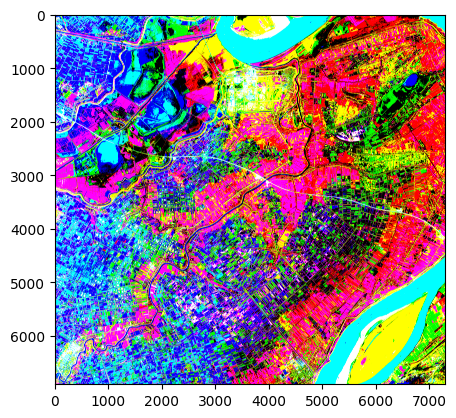

In [10]:
import matplotlib.pyplot as plt
plt.imshow(image_pca_3d)
import cv2
cv2.imwrite("pca_image_test.png", image_pca_3d)

# CODE TO GENERATE THE PCA DATASET

In [39]:
### Code to generate downsampled 3 channels images

# 1 Read the image
# 2 Apply the PCA transformation to the image
# 3 Divide thee image into quadrants
# 4 Store the donwsampled images

import os
from osgeo import gdal
from sklearn.decomposition import PCA
import numpy as np

def divide_image_into_quadrants(image, n):
    
    if(len(image.shape) == 3):
        rows, cols, _ = image.shape  
    else:
        rows, cols = image.shape  
    
    
    # Calculate the number of rows and columns for the grid
    num_rows = int(n ** 0.5)
    num_cols = n // num_rows
    
    # Calculate the dimensions of each quadrant
    quadrant_rows = rows // num_rows
    quadrant_cols = cols // num_cols
    
    # Initialize a list to store the quadrants
    quadrants = []
    
    # Iterate over the rows and columns to extract each quadrant
    for i in range(num_rows):
        for j in range(num_cols):
            # Define the region of interest (ROI) for the quadrant
            start_row = i * quadrant_rows
            end_row = start_row + quadrant_rows
            start_col = j * quadrant_cols
            end_col = start_col + quadrant_cols
            
            # Extract the quadrant
            quadrant = image[start_row:end_row, start_col:end_col]
            quadrants.append(quadrant)
    
    return quadrants

def downsample_image(image): # It expects a numpy array with shape (6908, 7300, 4)
    x, y, z = image.shape
    image_2d = image.reshape(x*y, z)

    pca = PCA(3)  # necesitamos quedar en 3 dimensiones
    image_pca = pca.fit_transform(image_2d)

    image_pca_3d = image_pca.reshape(x, y, 3)

    return image_pca_3d

def save_quadrants(quadrants, image_name, output_folder, projection, geotransform):

    #delete the extension from the image name
    image_name = os.path.splitext(image_name)[0]


    for idx, small_image in enumerate(quadrants):
        print(f"Saving {image_name} {idx+1}/{len(quadrants)}")
        
        cv2.imwrite(f'{output_folder}{image_name}_{idx}.png',small_image)

        """
        driver = gdal.GetDriverByName('GTiff')
        x_size = small_image.shape[0]
        y_size = small_image.shape[1]
        band_count = 3
        
        output_dataset = driver.Create(f'{output_folder}{image_name}_{idx}_.tif', x_size, y_size, band_count)

        output_dataset.SetProjection(projection)
        output_dataset.SetGeoTransform(geotransform)

        for band_index in range(band_count):
            output_band = output_dataset.GetRasterBand(band_index + 1)
            output_band.WriteArray(small_image[band_index])
            output_band.FlushCache()

        output_dataset = None 
        """
        print(f"Image {image_name} saved successfully.")
    



In [40]:
### Code to generate downsampled 3 channels images

# 1 Read the image
# 2 Apply the PCA transformation to the image
# 3 Divide thee image into quadrants
# 4 Store the donwsampled images


def setup_PCA_small_images(source_path, destination_path):
    for image_name in os.listdir(source_path):
        image_path = os.path.join(source_path, image_name)
        dataset = gdal.Open(image_path, gdal.GA_ReadOnly)


        """         
        x_size = dataset.RasterXSize
        y_size = dataset.RasterYSize
        band_count = dataset.RasterCount"""
        projection = dataset.GetProjection()
        geotransform = dataset.GetGeoTransform() 

        bands = []
        for band_index in range(1, dataset.RasterCount + 1):
            band = dataset.GetRasterBand(band_index)
            image = band.ReadAsArray()
            bands.append(image)
        image = np.stack(bands, axis=-1)
        dataset = None
        print("OG Image shape: ", image.shape)

        # Tengo la imagen guardada como un np.array
        # Ahora tengo que aplicar el PCA
        image_pca = downsample_image(image)
        print("PCA Image shape: ", image_pca.shape)

        
        #Dividir en cuatro
        quadrants = divide_image_into_quadrants(image_pca, 4)


        #Guardar los cuadrantes
        save_quadrants(quadrants, image_name, destination_path, projection, geotransform)
        
        




In [41]:
multi_images_train_source_path = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"
multi_images_train_destination_path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/train_PCA_V2/"
setup_PCA_small_images(multi_images_train_source_path, multi_images_train_destination_path)

OG Image shape:  (6908, 7300, 4)
PCA Image shape:  (6908, 7300, 3)
Saving GF2_PMS2__L1A0000958144-MSS2 1/4
Image GF2_PMS2__L1A0000958144-MSS2 saved successfully.
Saving GF2_PMS2__L1A0000958144-MSS2 2/4
Image GF2_PMS2__L1A0000958144-MSS2 saved successfully.
Saving GF2_PMS2__L1A0000958144-MSS2 3/4
Image GF2_PMS2__L1A0000958144-MSS2 saved successfully.
Saving GF2_PMS2__L1A0000958144-MSS2 4/4
Image GF2_PMS2__L1A0000958144-MSS2 saved successfully.
OG Image shape:  (6908, 7300, 4)
PCA Image shape:  (6908, 7300, 3)
Saving GF2_PMS2__L1A0001246645-MSS2 1/4
Image GF2_PMS2__L1A0001246645-MSS2 saved successfully.
Saving GF2_PMS2__L1A0001246645-MSS2 2/4
Image GF2_PMS2__L1A0001246645-MSS2 saved successfully.
Saving GF2_PMS2__L1A0001246645-MSS2 3/4
Image GF2_PMS2__L1A0001246645-MSS2 saved successfully.
Saving GF2_PMS2__L1A0001246645-MSS2 4/4
Image GF2_PMS2__L1A0001246645-MSS2 saved successfully.
OG Image shape:  (6908, 7300, 4)
PCA Image shape:  (6908, 7300, 3)
Saving GF2_PMS2__L1A0001757320-MSS2 1/4

In [42]:
multi_images_test_source_path = "/home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/"
multi_images_test_destination_path = "/home/pablo.canosa/wip/datasets/small_gaofen/test/test_PCA_V2/"
setup_PCA_small_images(multi_images_test_source_path, multi_images_test_destination_path)

OG Image shape:  (6908, 7300, 4)
PCA Image shape:  (6908, 7300, 3)
Saving GF2_PMS2__L1A0001367840-MSS2 1/4
Image GF2_PMS2__L1A0001367840-MSS2 saved successfully.
Saving GF2_PMS2__L1A0001367840-MSS2 2/4
Image GF2_PMS2__L1A0001367840-MSS2 saved successfully.
Saving GF2_PMS2__L1A0001367840-MSS2 3/4
Image GF2_PMS2__L1A0001367840-MSS2 saved successfully.
Saving GF2_PMS2__L1A0001367840-MSS2 4/4
Image GF2_PMS2__L1A0001367840-MSS2 saved successfully.
OG Image shape:  (6908, 7300, 4)
PCA Image shape:  (6908, 7300, 3)
Saving GF2_PMS1__L1A0001395956-MSS1 1/4
Image GF2_PMS1__L1A0001395956-MSS1 saved successfully.
Saving GF2_PMS1__L1A0001395956-MSS1 2/4
Image GF2_PMS1__L1A0001395956-MSS1 saved successfully.
Saving GF2_PMS1__L1A0001395956-MSS1 3/4
Image GF2_PMS1__L1A0001395956-MSS1 saved successfully.
Saving GF2_PMS1__L1A0001395956-MSS1 4/4
Image GF2_PMS1__L1A0001395956-MSS1 saved successfully.
OG Image shape:  (6908, 7300, 4)
PCA Image shape:  (6908, 7300, 3)
Saving GF2_PMS1__L1A0001118839-MSS1 1/4

In [49]:
# check if 2 folder have the same files

source_path = "/home/pablo.canosa/wip/datasets/small_gaofen/test/test_PCA/"
destination_path = "/home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images/"
for image_name in os.listdir(source_path):
    if image_name not in os.listdir(destination_path):
        print(f"Image {image_name} not found in destination folder")

source_path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/train_PCA/"
destination_path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/"
for image_name in os.listdir(source_path):
    if image_name not in os.listdir(destination_path):
        print(f"Image {image_name} not found in destination folder")
        

In [43]:
# check the images
import matplotlib.pyplot as plt

image_path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/train_PCA/GF2_PMS2__L1A0000958144-MSS2_0.tif"

dataset = gdal.Open(image_path, gdal.GA_ReadOnly)


x_size = dataset.RasterXSize
y_size = dataset.RasterYSize
band_count = dataset.RasterCount
projection = dataset.GetProjection()
geotransform = dataset.GetGeoTransform()

bands = []
for band_index in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(band_index)
    image = band.ReadAsArray()
    bands.append(image)
image = np.stack(bands, axis=-1)

print(image.shape)

cv2.imwrite("test_image.png", image)


(3454, 3650, 3)


True

In [4]:
import cv2
import matplotlib.pyplot as plt
image_path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/train_PCA/GF2_PMS1__L1A0000564539-MSS1_0.tif"
cv2_image = cv2.imread(image_path)




[ WARN:0@195.605] global grfmt_tiff.cpp:714 readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 64-bit samples


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
from osgeo import gdal
import numpy as np

tiff_file_path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/train_PCA/GF2_PMS1__L1A0000564539-MSS1_0.tiff"
dataset = gdal.Open(tiff_file_path, gdal.GA_ReadOnly)

if not dataset:
    print(f"Failed to open the file {image}.")
else:
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    band_count = dataset.RasterCount
    projection = dataset.GetProjection()
    geotransform = dataset.GetGeoTransform()

bands = []
for band_index in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(band_index)
    image = band.ReadAsArray()
    bands.append(image)
image = np.stack(bands, axis=-1)
dataset = None
print(image.shape)
print(image.dtype)
plt.imshow(image)


Failed to open the file [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 ...

 [[  0   0 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]].


ERROR 4: /home/pablo.canosa/wip/datasets/small_gaofen/train/train_PCA/GF2_PMS1__L1A0000564539-MSS1_0.tiff: No such file or directory


AttributeError: 'NoneType' object has no attribute 'RasterCount'

OG Image shape:  (6908, 7300, 3)
Image_pca shape:  (6908, 7300, 3)
Image_pca max:  255
Image_pca min:  0
Image_pca mean:  34.58371450082361
Image_pca std:  63.82061168058944


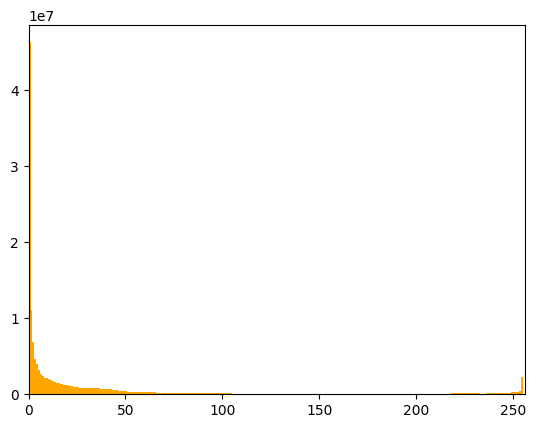

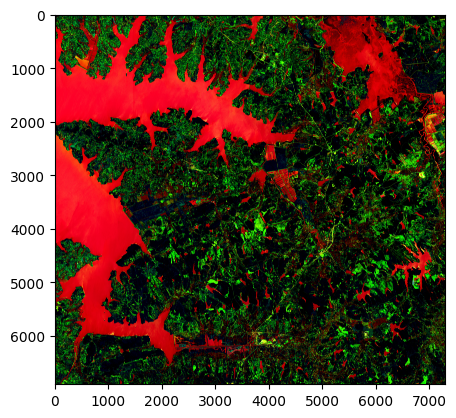

OG Image shape:  (3454, 3650, 3)
Image_pca shape:  (3454, 3650, 3)
Image_pca max:  255
Image_pca min:  0
Image_pca mean:  83.20623505802286
Image_pca std:  60.40468360701554


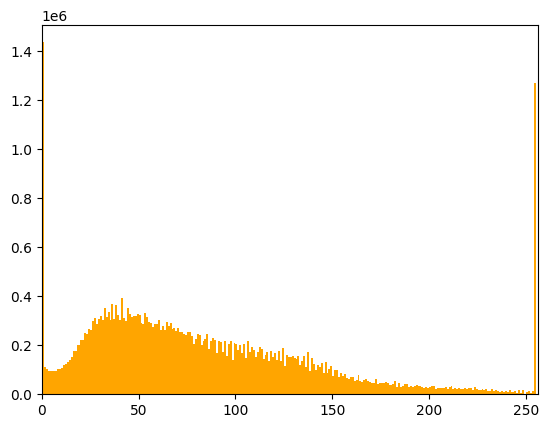

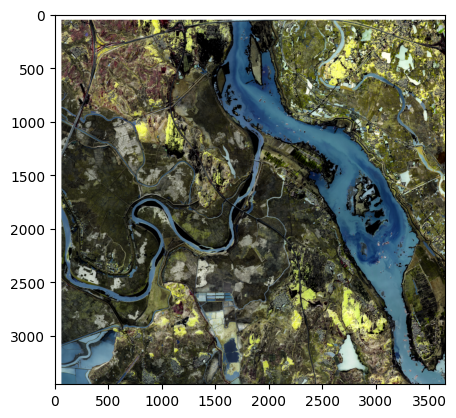

In [26]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import cv2

path = "/home/pablo.canosa/wip/prueba.jpeg"
image = cv2.imread(path)
print("OG Image shape: ", image.shape)
print("Image_pca shape: ", image.shape)
print("Image_pca max: ", image.max())
print("Image_pca min: ", image.min())
print("Image_pca mean: ", image.mean())
print("Image_pca std: ", image.std())
plt.hist(image.ravel(), bins = 255, color = 'orange', )
plt.xlim([0,256])
plt.show()
plt.imshow(image)
plt.show()


path = "/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0000564539-MSS1_0.tif"
image = cv2.imread(path)
print("OG Image shape: ", image.shape)
print("Image_pca shape: ", image.shape)
print("Image_pca max: ", image.max())
print("Image_pca min: ", image.min())
print("Image_pca mean: ", image.mean())
print("Image_pca std: ", image.std())
plt.hist(image.ravel(), bins = 255, color = 'orange', )
plt.xlim([0,256])
plt.show()
plt.imshow(image)
plt.show()

# Read JSON and plot

In [33]:
# Path to the file to be used to generate graphics to be used in the paper

file_path = "/home/pablo.canosa/wip/Mask2Former/output/metrics.json"

dict_keys(['data_time', 'eta_seconds', 'iteration', 'loss_ce', 'loss_ce_0', 'loss_ce_1', 'loss_ce_2', 'loss_ce_3', 'loss_ce_4', 'loss_ce_5', 'loss_ce_6', 'loss_ce_7', 'loss_ce_8', 'loss_dice', 'loss_dice_0', 'loss_dice_1', 'loss_dice_2', 'loss_dice_3', 'loss_dice_4', 'loss_dice_5', 'loss_dice_6', 'loss_dice_7', 'loss_dice_8', 'loss_mask', 'loss_mask_0', 'loss_mask_1', 'loss_mask_2', 'loss_mask_3', 'loss_mask_4', 'loss_mask_5', 'loss_mask_6', 'loss_mask_7', 'loss_mask_8', 'lr', 'rank_data_time', 'time', 'total_loss'])


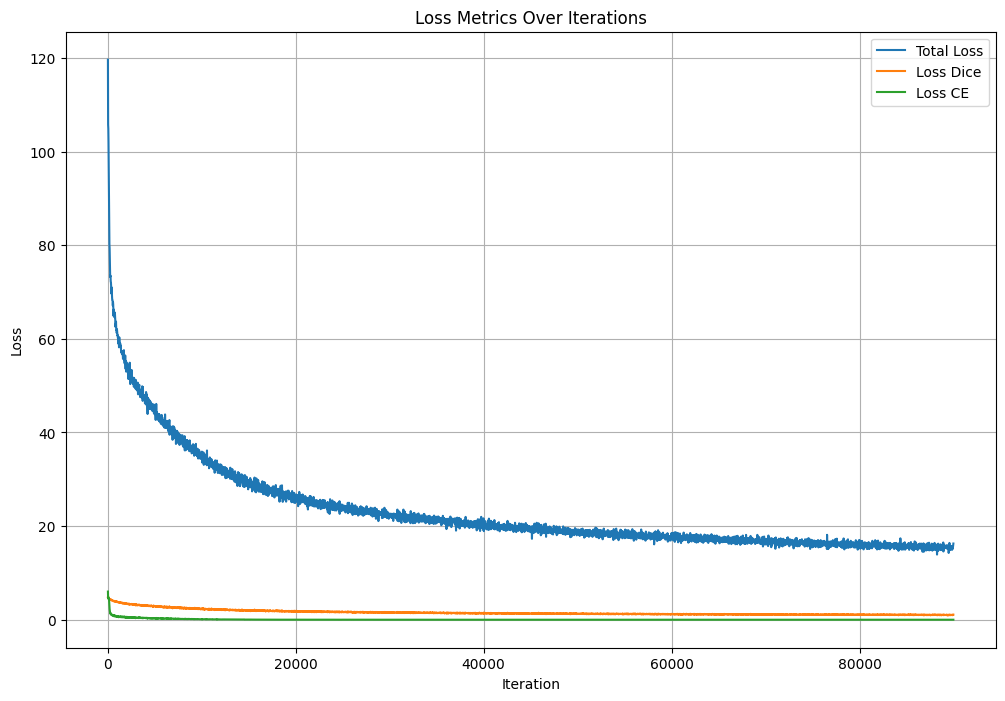

In [38]:
import json
import matplotlib.pyplot as plt

data = []
with open(file_path, 'r') as f:
    for line in f:
        try:
            json_object = json.loads(line.strip())
            data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(e)

print(data[0].keys())  


iterations = []
total_losses = []
loss_dices = []
loss_ces = []

for entry in data:
    if all(key in entry for key in ['iteration', 'total_loss', 'loss_dice', 'loss_ce']):
        iterations.append(entry['iteration'])
        total_losses.append(entry['total_loss'])
        loss_dices.append(entry['loss_dice'])
        loss_ces.append(entry['loss_ce'])
    else:
        print(f"Skipping entry due to missing keys: {entry}")

plt.figure(figsize=(12, 8))

plt.plot(iterations, total_losses, label='Total Loss')
plt.plot(iterations, loss_dices, label='Loss Dice')
plt.plot(iterations, loss_ces, label='Loss CE')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Metrics Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

dict_keys(['data_time', 'eta_seconds', 'iteration', 'loss_ce', 'loss_ce_0', 'loss_ce_1', 'loss_ce_2', 'loss_ce_3', 'loss_ce_4', 'loss_ce_5', 'loss_ce_6', 'loss_ce_7', 'loss_ce_8', 'loss_dice', 'loss_dice_0', 'loss_dice_1', 'loss_dice_2', 'loss_dice_3', 'loss_dice_4', 'loss_dice_5', 'loss_dice_6', 'loss_dice_7', 'loss_dice_8', 'loss_mask', 'loss_mask_0', 'loss_mask_1', 'loss_mask_2', 'loss_mask_3', 'loss_mask_4', 'loss_mask_5', 'loss_mask_6', 'loss_mask_7', 'loss_mask_8', 'lr', 'rank_data_time', 'time', 'total_loss'])
9999 :  40.81576397830869
19999 :  42.998412440957566
29999 :  43.401628710310334
39999 :  43.19749180108527
49999 :  42.79972787551773
59999 :  43.23398569401164
69999 :  42.761618062987885
79999 :  41.76915130390764


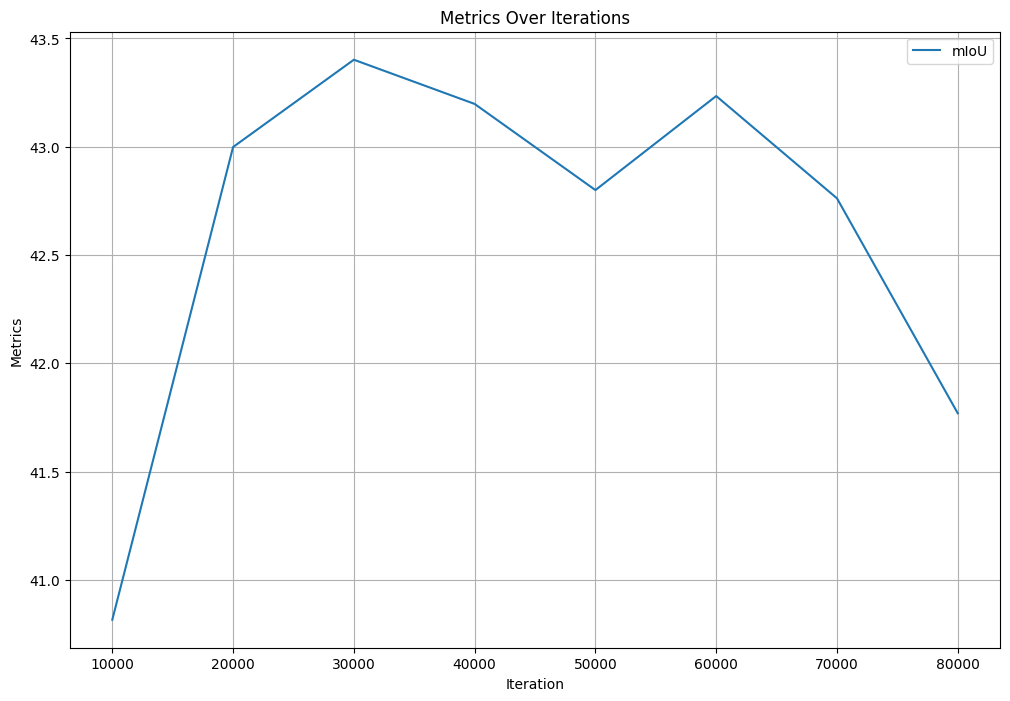

In [39]:
data = []
with open(file_path, 'r') as f:
    for line in f:
        try:
            json_object = json.loads(line.strip())
            data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(e)

print(data[250].keys())

iterations = []
pACC = []
fwIoU = []
mACC = []
mIoU = []

for entry in data:
    if all(key in entry for key in ['iteration', 'sem_seg_NEW/pACC', 'sem_seg_NEW/fwIoU', 'sem_seg_NEW/mACC', 'sem_seg_NEW/mIoU',]):
        iterations.append(entry['iteration'])
        pACC.append(entry['sem_seg_NEW/pACC'])
        fwIoU.append(entry['sem_seg_NEW/fwIoU'])
        mACC.append(entry['sem_seg_NEW/mACC'])
        mIoU.append(entry['sem_seg_NEW/mIoU'])
        print(iterations[-1]) # Está mal porque mezcla varios entrenamientos

plt.figure(figsize=(12, 8))

plt.plot(iterations, pACC, label='pACC')
plt.plot(iterations, fwIoU, label='fwIoU')
plt.plot(iterations, mACC, label='mACC')
plt.plot(iterations, mIoU, label='mIoU')

plt.xlabel('Iteration')
plt.ylabel('Metrics')
plt.title('Metrics Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


# Calculate pixel mean and STD


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


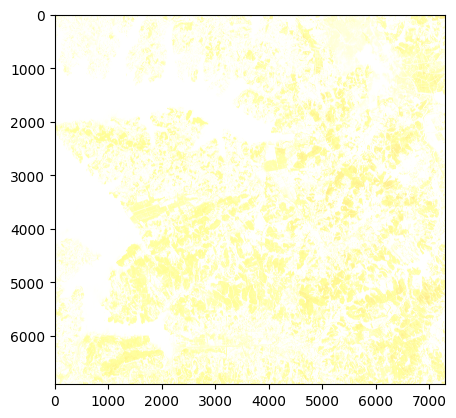

Image shape:  (6908, 7300, 4)
Image max:  1004
Image min:  0
Image mean:  333.5460922069707
Image type:  uint16


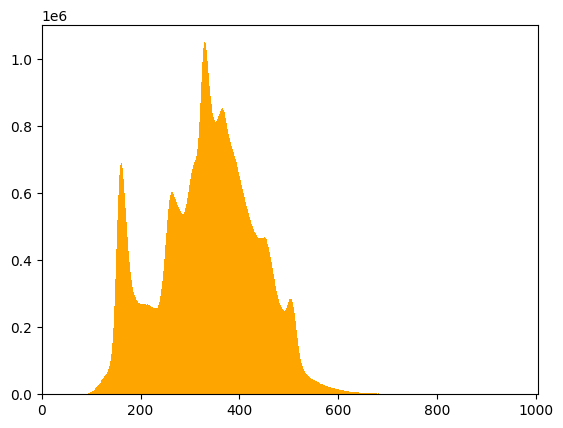

Image shape:  (6908, 7300, 4)
Image max:  255
Image min:  0
Image mean:  84.22111976088871
Image type:  uint8


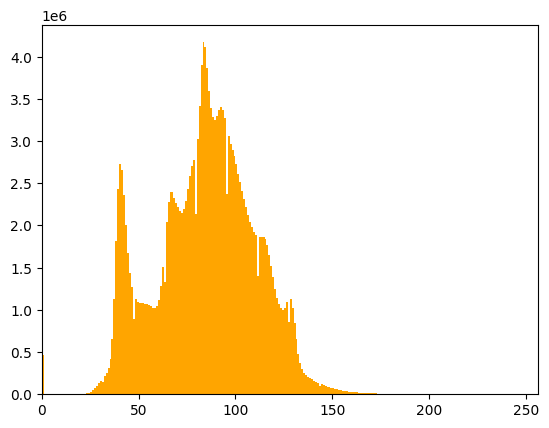

Means:  nan
Stds:  nan


/home/pablo.canosa/miniconda3/envs/mask2former/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pablo.canosa/miniconda3/envs/mask2former/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
from osgeo import gdal
import os
import numpy as np        
path_multi_16bit_full = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"
# calculate the mean and std of all bands in the images
means = []
stds = []

for image in os.listdir(path_multi_16bit_full):
    dataset = gdal.Open(path_multi_16bit_full+image, gdal.GA_ReadOnly)
    
    bands = []
    for band_index in range(1, dataset.RasterCount + 1):
        band = dataset.GetRasterBand(band_index)
        image = band.ReadAsArray()
        bands.append(image)
    image = np.stack(bands, axis=-1)
    #
    plt.imshow(image)
    plt.show()
    # show image info
    print("Image shape: ", image.shape)
    print("Image max: ", image.max())
    print("Image min: ", image.min())
    print("Image mean: ", image.mean())
    print("Image type: ", image.dtype)
    # plot values in a histogram
    plt.hist(image.ravel(), bins = image.max(), color = 'orange', )
    plt.xlim([0,1004])
    plt.show()

    #image = (image / 256).astype(np.uint8)# IF THE BANDS ARE IN UINT16 FORMAT IT'S INCOMPATIBLE WITH MASK2FORMER, THEY ARE CONVERTED TO UINT8
    # HACER ESTO PERO POR BANDA
    image = (image / image.max()) * 255.0

    # Convert the data type to uint8
    image = image.astype(np.uint8)
    print("Image shape: ", image.shape)
    print("Image max: ", image.max())
    print("Image min: ", image.min())
    print("Image mean: ", image.mean())
    print("Image type: ", image.dtype)
    # plot values in a histogram
    plt.hist(image.ravel(), bins = 255, color = 'orange', )
    plt.xlim([0,256])
    plt.show()

    # save the image 
    im = Image.fromarray(image)
    im.save('test.tif')



    break
    #means.append(image.mean())
    #stds.append(image.std())


# Check image values

Image opened with pillow and converted to CMYK
Image shape:  (7300, 6908)


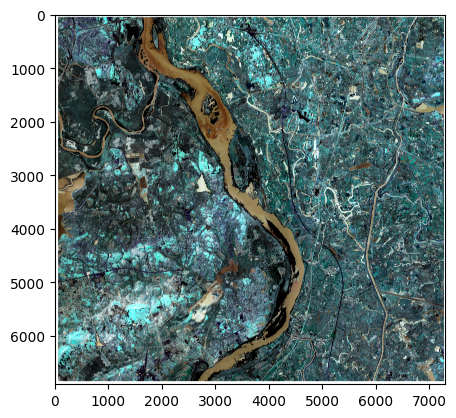

Image opened with pillow without conversion
Image shape:  (7300, 6908)


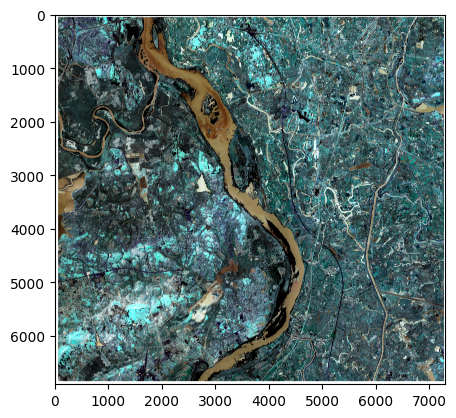

Image opened with pillow and converted to RGBA
Image shape:  (7300, 6908)


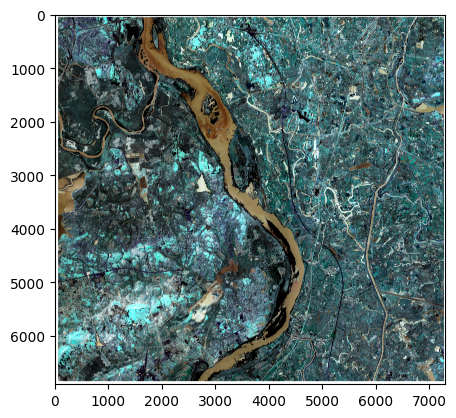

Image opened with cv2
Image shape:  (6908, 7300, 3)


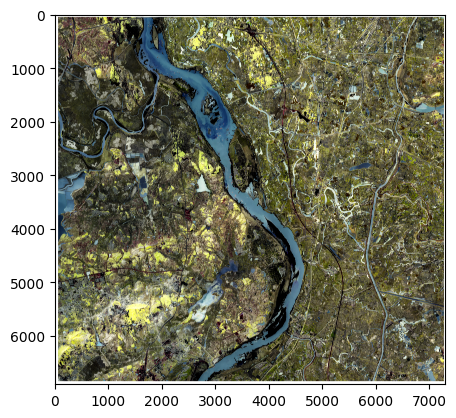

Image opened with tifffile
Image shape:  (6908, 7300, 4)


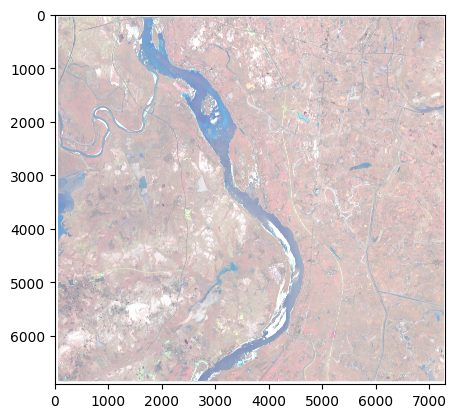

In [73]:
# import pillow image
from PIL import Image
import cv2
import tifffile as tiff
image_8bit_path = "/home/pablo.canosa/old_tfm_data/gaofen/Image__8bit_NirRGB/GF2_PMS1__L1A0000564539-MSS1.tif"


print("Image opened with pillow and converted to CMYK")
image = Image.open(image_8bit_path).convert('CMYK')
print("Image shape: ", image.size)

plt.imshow(image)
plt.show()

# Opening the same image with pillow without cmyk conversion
print("Image opened with pillow without conversion")
image = Image.open(image_8bit_path)
print("Image shape: ", image.size)

plt.imshow(image)
plt.show()

# Opening the same image with pillow and converting it to RGBA
print("Image opened with pillow and converted to RGBA")
image = Image.open(image_8bit_path).convert('RGBA')
print("Image shape: ", image.size)

plt.imshow(image)
plt.show()


# Opening the same image with cv2   
print("Image opened with cv2")
image = cv2.imread(image_8bit_path)
print("Image shape: ", image.shape)

plt.imshow(image)
plt.show()

# Opening the same image with tifffile

print("Image opened with tifffile")
image = tiff.imread(image_8bit_path)
print("Image shape: ", image.shape)

plt.imshow(image)
plt.show()






In [48]:
band_index = 4

#image_8bit_folder_path = "/home/pablo.canosa/old_tfm_data/gaofen/Image_16bit_BGRNir/"
image_8bit_folder_path = "/home/pablo.canosa/old_tfm_data/gaofen/Image__8bit_NirRGB/"

for image in os.listdir(image_8bit_folder_path):
    image_path = os.path.join(image_8bit_folder_path, image)
    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    band = dataset.GetRasterBand(band_index)
    image = band.ReadAsArray()
    if image.max() == 255 and image.min() == 255:
        print("-----")
    else:
        print("ÉXITO")



-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----


Image shape:  (7300, 6908)


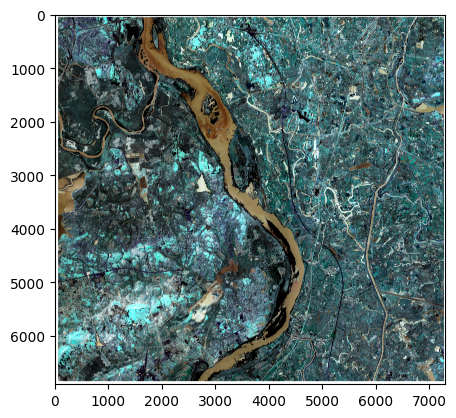

In [65]:
# read image with pillow and convert it to cmky
from PIL import Image
image_path = "/home/pablo.canosa/old_tfm_data/gaofen/Image__8bit_NirRGB/GF2_PMS1__L1A0000564539-MSS1.tif"
image = Image.open(image_path).convert('CMYK')
print("Image shape: ", image.size)
plt.imshow(image)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


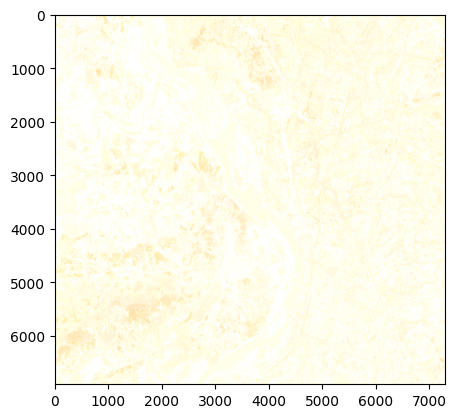

Image shape:  (6908, 7300, 4)
Image max:  961
Image min:  0
Image mean:  275.34121882213196
Image type:  uint16


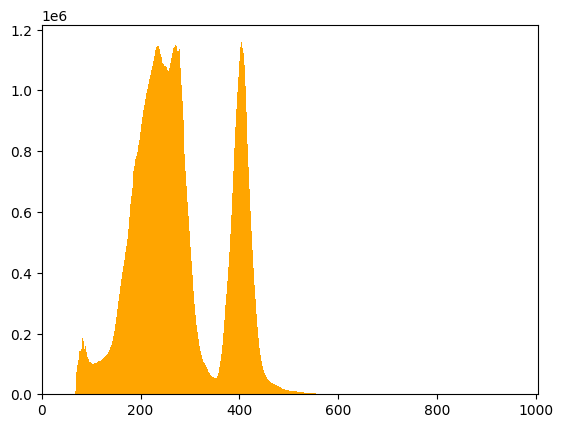

Image shape:  (6908, 7300, 4)
Image max:  255
Image min:  0
Image mean:  72.56002029610299
Image type:  uint8


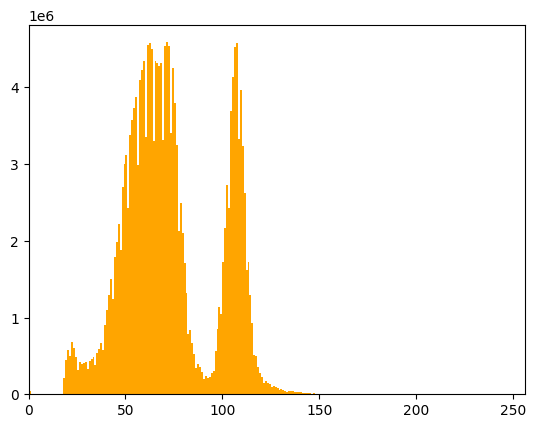

In [53]:
path_multi_16bit_full = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"
# calculate the mean and std of all bands in the images
means = []
stds = []
image_path = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000564539-MSS1.tiff"
dataset = gdal.Open(image_path, gdal.GA_ReadOnly)

bands = []
for band_index in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(band_index)
    image = band.ReadAsArray()
    bands.append(image)
image = np.stack(bands, axis=-1)
#
plt.imshow(image)
plt.show()
# show image info
print("Image shape: ", image.shape)
print("Image max: ", image.max())
print("Image min: ", image.min())
print("Image mean: ", image.mean())
print("Image type: ", image.dtype)
# plot values in a histogram
plt.hist(image.ravel(), bins = image.max(), color = 'orange', )
plt.xlim([0,1004])
plt.show()

#image = (image / 256).astype(np.uint8)# IF THE BANDS ARE IN UINT16 FORMAT IT'S INCOMPATIBLE WITH MASK2FORMER, THEY ARE CONVERTED TO UINT8
image = (image / image.max()) * 255.0

image = image.astype(np.uint8)
print("Image shape: ", image.shape)
print("Image max: ", image.max())
print("Image min: ", image.min())
print("Image mean: ", image.mean())
print("Image type: ", image.dtype)
# plot values in a histogram
plt.hist(image.ravel(), bins = 255, color = 'orange', )
plt.xlim([0,256])
plt.show()

# save the image 
im = Image.fromarray(image)
im.save('test.tif')


## Generate 4ths of multi images



In [28]:
#import 
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os


def read_image_multi(path):
    # Read image using GDAL
    dataset = gdal.Open(path, gdal.GA_ReadOnly)
    bands = []
    # keep projection
    projection = dataset.GetProjection()
    # keep geotransform
    geotransform = dataset.GetGeoTransform()
    for band_index in range(1, dataset.RasterCount + 1):
        band = dataset.GetRasterBand(band_index)
        image = band.ReadAsArray()
        bands.append(image)
    image = np.stack(bands, axis=-1)

    return image, projection, geotransform

def divide_image_into_quadrants(image, n):
    
    if(len(image.shape) == 3):
        rows, cols, _ = image.shape  
    else:
        rows, cols = image.shape  
    
    
    # Calculate the number of rows and columns for the grid
    num_rows = int(n ** 0.5)
    num_cols = n // num_rows
    
    # Calculate the dimensions of each quadrant
    quadrant_rows = rows // num_rows
    quadrant_cols = cols // num_cols
    
    # Initialize a list to store the quadrants
    quadrants = []
    
    # Iterate over the rows and columns to extract each quadrant
    for i in range(num_rows):
        for j in range(num_cols):
            # Define the region of interest (ROI) for the quadrant
            start_row = i * quadrant_rows
            end_row = start_row + quadrant_rows
            start_col = j * quadrant_cols
            end_col = start_col + quadrant_cols
            
            # Extract the quadrant
            quadrant = image[start_row:end_row, start_col:end_col]
            quadrants.append(quadrant)
    
    return quadrants

def save_quadrants(quadrants, image_name, output_folder, projection, geotransform):
    
        #delete the extension from the image name
        image_name = os.path.splitext(image_name)[0]
    
    
        for idx, small_image in enumerate(quadrants):
            print(f"Saving {image_name} {idx+1}/{len(quadrants)}")
            
            cv2.imwrite(f'{output_folder}{image_name}_{idx}.png',small_image)
    


            print(f"Image {image_name} saved successfully.")


def save_image_gdal(image, output_path, projection, geotransform):
    driver = gdal.GetDriverByName('GTiff')
    
    # Image shape
    y_size, x_size, band_count = image.shape
    
    print(f"Image shape: {image.shape}")
    print(f"x_size: {x_size}, y_size: {y_size}, band_count: {band_count}")
    
    # Create the output dataset
    output_dataset = driver.Create(output_path, x_size, y_size, band_count, gdal.GDT_UInt16)
    if output_dataset is None:
        raise RuntimeError(f"Failed to create output dataset {output_path}")
    
    output_dataset.SetProjection(projection)
    output_dataset.SetGeoTransform(geotransform)

    # Verify dataset dimensions
    print(f"Output dataset dimensions: {output_dataset.RasterXSize}x{output_dataset.RasterYSize} with {output_dataset.RasterCount} bands")
    
    # Write each band
    for band_index in range(band_count):
        output_band = output_dataset.GetRasterBand(band_index + 1)
        print(f"Writing band {band_index + 1}")
        output_band.WriteArray(image[:, :, band_index])
        output_band.FlushCache()

    # Properly close the dataset
    output_dataset = None
    print(f"Image saved to {output_path}")


def create_small_16bit(image_path, output_folder):
    for image_name in os.listdir(image_path):
        image, projection, geotransform = read_image_multi(image_path+image_name)
        quadrants = divide_image_into_quadrants(image, 4)

        image_name = os.path.splitext(image_name)[0]
        for idx, small_image in enumerate(quadrants):
            print(f"Saving {image_path} {idx+1}/{len(quadrants)}")
            save_image_gdal(small_image, f'{output_folder}{image_name}_{idx}.tiff', projection, geotransform)
    #save_image_gdal(image, output_path, projection, geotransform)

In [30]:
folder_source = "/home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/"

folder_destination = "/home/pablo.canosa/wip/datasets/small_gaofen/test/test_16bit_images/"

create_small_16bit(folder_source, folder_destination)

Saving /home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/ 1/4
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/test/test_16bit_images/GF2_PMS2__L1A0001367840-MSS2_0.tiff
Saving /home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/ 2/4
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/test/test_16bit_images/GF2_PMS2__L1A0001367840-MSS2_1.tiff
Saving /home/pablo.canosa/wip/datasets/split_gaofen/test_16bit/ 3/4
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to 

In [31]:
folder_source = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"

folder_destination = "/home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/"

create_small_16bit(folder_source, folder_destination)

Saving /home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/ 1/4
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/GF2_PMS2__L1A0000958144-MSS2_0.tiff
Saving /home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/ 2/4
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/GF2_PMS2__L1A0000958144-MSS2_1.tiff
Saving /home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/ 3/4
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


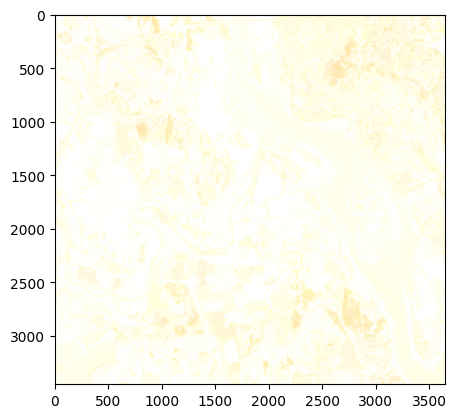

Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/GF2_PMS1__L1A0000564539-MSS1.tiff_0.tiff
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/GF2_PMS1__L1A0000564539-MSS1.tiff_1.tiff
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions: 3650x3454 with 4 bands
Writing band 1
Writing band 2
Writing band 3
Writing band 4
Image saved to /home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/GF2_PMS1__L1A0000564539-MSS1.tiff_2.tiff
Image shape: (3454, 3650, 4)
x_size: 3650, y_size: 3454, band_count: 4
Output dataset dimensions:

In [24]:
# import image from pillow
from PIL import Image

image_trial_source = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/GF2_PMS1__L1A0000564539-MSS1.tiff"

image, projection, geotransform = read_image_multi(image_trial_source)

divided_images = divide_image_into_quadrants(image, 4)

plt.imshow(divided_images[0])
plt.show()

# Save image using tiff
import tifffile as tiff

tiff.imwrite('test.tif', divided_images[0])## Asi en terminos generales se puede guardar la imagen

# Save an image using GDAL

folder_destination = "/home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/"

image_name = "GF2_PMS1__L1A0000564539-MSS1.tiff"

for idx, small_image in enumerate(divided_images):
    output_path = f'{folder_destination}{image_name}_{idx}.tiff'
    save_image_gdal(small_image, output_path, projection, geotransform)







In [ ]:


folder_source = "/home/pablo.canosa/wip/datasets/split_gaofen/train_16bit/"

folder_destination = "/home/pablo.canosa/wip/datasets/small_gaofen/train/16bit_images/"